Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy:  0.9364548494983278


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


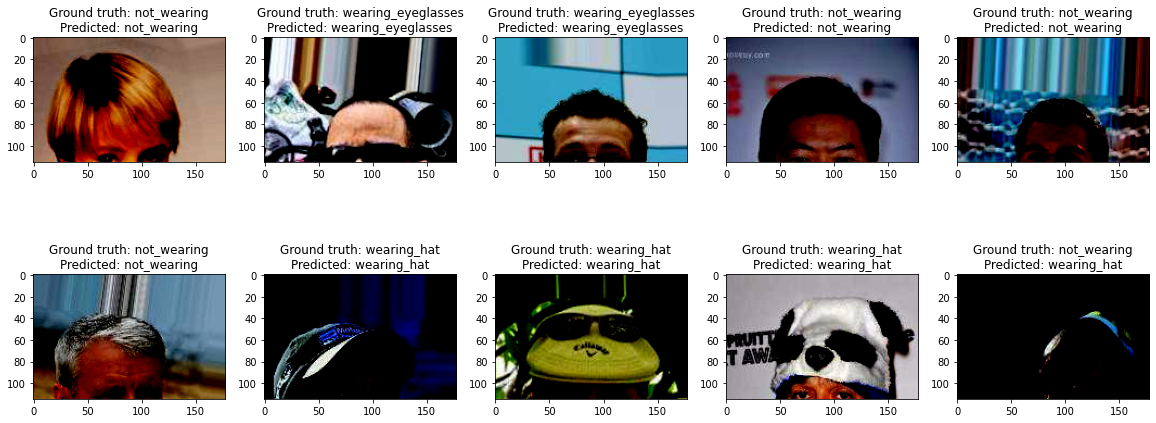

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision
import torch.nn.functional as nnfunc
from skimage import filters
from torchvision.transforms import functional_tensor as F_t

class Crop(object):
    def __call__(self, img):
        return F_t.crop(img, 0, 0, 115, 218)

def ResBlock(in_channels, out_channels, pool=False):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU(inplace=True))
    if pool: 
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
    
def BasicBlock(in_channels, out_channels, max_pool=False):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU(inplace=True))
    if max_pool: 
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = BasicBlock(in_channels, 64)
        self.conv2 = BasicBlock(64, 128, max_pool=True)
        self.res1 = nn.Sequential(BasicBlock(128, 128), BasicBlock(128, 128))
        self.conv3 = BasicBlock(128, 256, max_pool=True)
        self.conv4 = BasicBlock(256, 512, max_pool=True)
        self.res2 = nn.Sequential(BasicBlock(512, 512), BasicBlock(512, 512))
        self.fc = nn.Sequential(nn.MaxPool2d(4), nn.Flatten(), nn.Dropout(0.2), nn.Linear(512, num_classes))
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.fc(out)
        return out

classes = ['not_wearing','wearing_eyeglasses','wearing_hat']

transformer = transforms.Compose([
    transforms.ToTensor(),
    Crop(),
#     transforms.Resize(32),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

test_path = 'data_wearing/test'

dataset = torchvision.datasets.ImageFolder(test_path, transform=transformer)

dataloader = DataLoader(
    dataset,
    batch_size = 256,
    shuffle = True
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNet9(3,3)
model = torchvision.models.resnet18(pretrained=False)
inchannel = model.fc.in_features
model.fc = nn.Linear(inchannel, 3)
best_model = torch.load('model/task2-best.model')
model.load_state_dict(best_model, strict=False)
model.to(device)
count = len(dataset)
model.eval()
sum_accuracy = 0.0

for i, (images, labels) in enumerate(dataloader):
    if torch.cuda.is_available():
        images = images.to(device)
        labels = labels.to(device)
    outputs = model(images)
    _,prediction = torch.max(outputs.data,1)
    sum_accuracy += int(torch.sum(prediction==labels.data))
accuracy = sum_accuracy / count

print(f'Accuracy: ', accuracy)

f = plt.figure(figsize=(20,8))
for i in range(10):
    subfigure = f.add_subplot(2, 5, i+1)
    subfigure.title.set_text("Ground Truth: " + classes[labels.data[i]] + "\nPredicted: " + classes[prediction[i]])
    img = images[i].numpy()
    subfigure.imshow(np.moveaxis(img, 0, -1))
plt.show()